In [116]:
# ===========================================
# AFL Fan Sentiment Analysis - DATA7703 Project
# Integrating Reddit Fan Reactions with AFL Match Results
# ===========================================

# SECTION 1: IMPORT LIBRARIES & LOAD DATA


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set visualization style
plt.style.use("ggplot")

# Load datasets
comments1 = pd.read_csv("afl_comments.csv")
comments2 = pd.read_csv("afl_comments2.csv")
comments = pd.concat([comments1, comments2])
post1 = pd.read_csv("afl_posts.csv")
post2 = pd.read_csv("afl_posts2.csv")
posts = pd.concat([post1, post2])
results_2024 = pd.read_csv("afl_results_2024.csv")
results_2025 = pd.read_csv("afl_results_2025.csv")

# Preview dataset shapes and columns
print("Dataset Overview:\n")
print(f"Comments: {comments.shape}, Columns: {list(comments.columns)}")
print(f"Posts: {posts.shape}, Columns: {list(posts.columns)}")
print(f"2024 Results: {results_2024.shape}, Columns: {list(results_2024.columns)}")
print(f"2025 Results: {results_2025.shape}, Columns: {list(results_2025.columns)}")

# Display first few rows for inspection
comments.head()


Dataset Overview:

Comments: (61596, 9), Columns: ['id', 'link_id', 'parent_id', 'submission_id', 'author', 'score', 'created_utc', 'created_datetime_utc', 'body']
Posts: (2049, 15), Columns: ['id', 'title', 'author', 'score', 'num_comments', 'created_utc', 'created_datetime_utc', 'url', 'permalink', 'subreddit', 'over_18', 'locked', 'stickied', 'is_self', 'selftext']
2024 Results: (216, 17), Columns: ['season', 'round', 'date_utc', 'venue', 'home_team', 'away_team', 'home_goals', 'home_behinds', 'home_score', 'away_goals', 'away_behinds', 'away_score', 'winner_team', 'margin', 'is_final', 'is_grand_final', 'game_id']
2025 Results: (216, 17), Columns: ['season', 'round', 'date_utc', 'venue', 'home_team', 'away_team', 'home_goals', 'home_behinds', 'home_score', 'away_goals', 'away_behinds', 'away_score', 'winner_team', 'margin', 'is_final', 'is_grand_final', 'game_id']


,id,link_id,parent_id,submission_id,author,score,created_utc,created_datetime_utc,body
0,nehu99r,t3_1nickz6,t3_1nickz6,1nickz6,juggboat,42,1.758015e+09,2025-09-16T09:25:04+00:00,I think it's more that clubs wised up and got ...
1,nehuf3r,t3_1nickz6,t3_1nickz6,1nickz6,GreenOnions69,16,1.758015e+09,2025-09-16T09:26:42+00:00,GWS's mad monday allegations didn't show up un...
2,nehvpep,t3_1nickz6,t3_1nickz6,1nickz6,ThePilingViking,8,1.758016e+09,2025-09-16T09:39:36+00:00,"Probably just doing this more in private, whic..."
3,nehwlsp,t3_1nickz6,t3_1nickz6,1nickz6,Certain_Impress_1005,6,1.758016e+09,2025-09-16T09:48:24+00:00,just wait for geelong
4,nehy330,t3_1nickz6,t3_1nickz6,1nickz6,MillionKarma23,5,1.758017e+09,2025-09-16T10:02:41+00:00,Because Geelong aren’t out yet


In [ ]:
# SECTION 2: CLEAN REDDIT COMMENTS
# -------------------------------------------
# Goal: Prepare comments for AFL sentiment analysis.
# - Remove deleted/invalid comments
# - Filter low-quality comments (score ≤ 1)
# - Clean text: lowercase, remove punctuation, links, etc.

# Make a copy to preserve raw data
comments_clean = comments.copy()

# Remove deleted/removed or NaN comments
comments_clean = comments_clean[~comments_clean["body"].isin(["[deleted]", "[removed]"])]
comments_clean = comments_clean.dropna(subset=["body"])

# Filter for valid comment scores (your rule: score > 1)
comments_clean = comments_clean[comments_clean["score"] > 1]

# Convert timestamp column to datetime
comments_clean["created_datetime_utc"] = pd.to_datetime(
    comments_clean["created_datetime_utc"], errors="coerce"
)

# Define a simple text cleaning function
def clean_text(text):
    text = text.lower()  # lowercase all text
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()  # remove extra spaces
    return text

# Apply the cleaner to comment text
comments_clean["clean_body"] = comments_clean["body"].apply(clean_text)

# Display cleaning progress
print(f"Original comments: {len(comments)}")
print(f"Cleaned comments: {len(comments_clean)}")
print(f"Removed percentage: {round((1 - len(comments_clean) / len(comments)) * 100, 2)}%")

# Preview cleaned text
comments_clean[["body", "clean_body"]].sample(5, random_state=42)


Original comments: 61596
Cleaned comments: 44599
Removed percentage: 27.59%


,body,clean_body
21231,"They’re not allowed to be, they asked ch7 and ...",theyre not allowed to be they asked ch and got...
25655,How has Clark still not come off for a HIA? He...,how has clark still not come off for a hia he ...
22349,Could’ve sworn I heard Brayshaw say Freo would...,couldve sworn i heard brayshaw say freo would ...
4112,I’m just looking looking forward to South Aust...,im just looking looking forward to south austr...
4933,#💦😫,


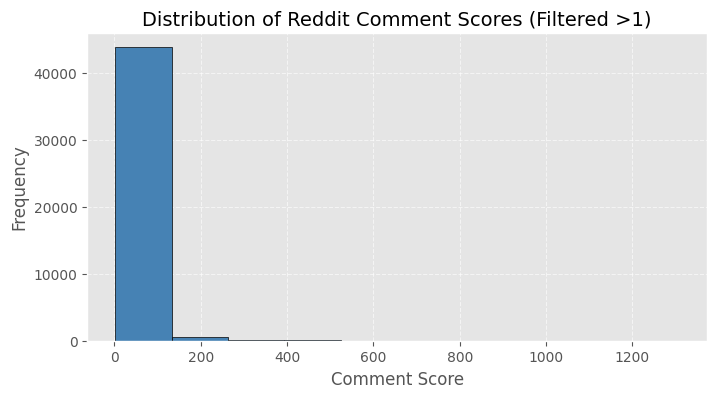

In [6]:
# VISUALIZATION 1: DISTRIBUTION OF COMMENT SCORES
# ------------------------------------------------
# Helps understand how active and influential the Reddit community is.

plt.figure(figsize=(8, 4))
plt.hist(comments_clean["score"], bins=10, color="steelblue", edgecolor="black")
plt.title("Distribution of Reddit Comment Scores (Filtered >1)", fontsize=14)
plt.xlabel("Comment Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


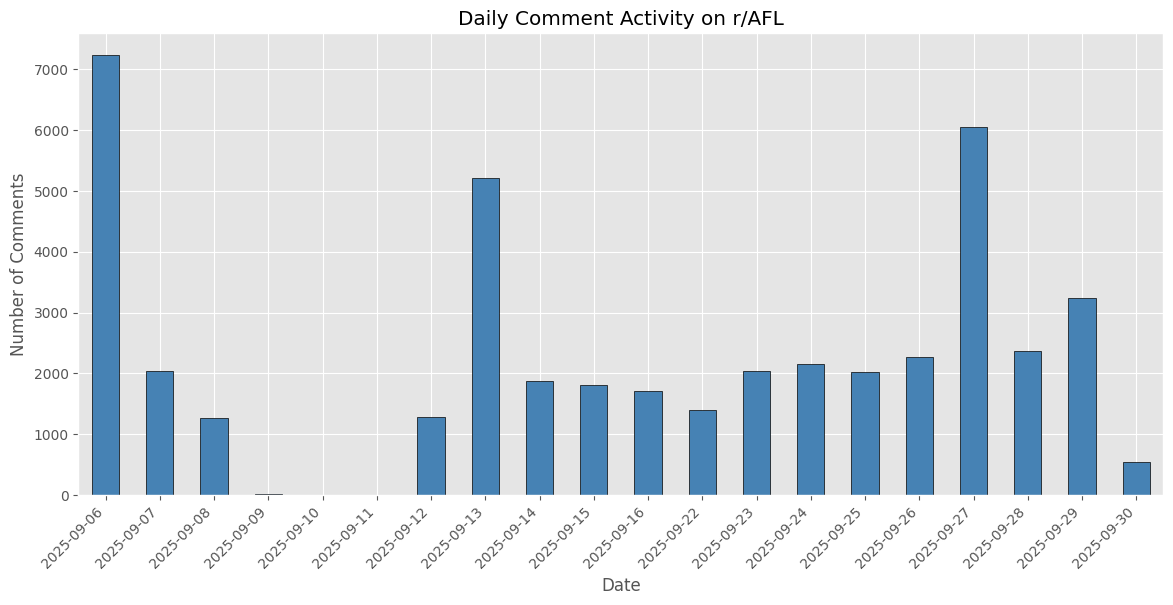

In [135]:
filtered_comments = comments_clean[comments_clean["created_datetime_utc"] <= '2025-10-01']

# Count comments per day
daily_counts = filtered_comments.groupby(
    filtered_comments["created_datetime_utc"].dt.date
).size()

# Create visualization
plt.figure(figsize=(14, 6))
daily_counts.plot(kind="bar", color='steelblue', edgecolor='black', linewidth=0.5)
plt.title("Daily Comment Activity on r/AFL",)
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45, ha='right')
plt.show()


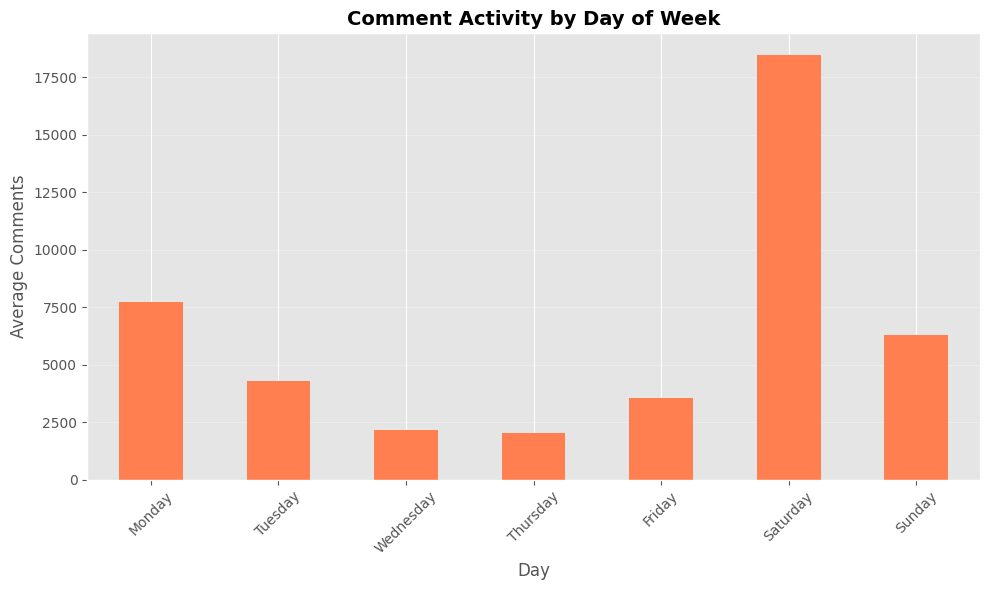

In [131]:
comments_clean["day_of_week"] = comments_clean["created_datetime_utc"].dt.day_name()
weekday_counts = comments_clean.groupby("day_of_week").size()

# Reorder days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(day_order)

plt.figure(figsize=(10, 6))
weekday_counts.plot(kind="bar", color='coral')
plt.title("Comment Activity by Day of Week", fontsize=14, fontweight='bold')
plt.xlabel("Day", fontsize=12)
plt.ylabel("Average Comments", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# ===========================================
# SECTION 3: CLEAN REDDIT POSTS
# -------------------------------------------
# Goal: Prepare Reddit post data for integration with comments and matches.
# - Combine 'title' and 'selftext' to form one unified text field.
# - Remove empty, locked, or irrelevant posts.
# - Clean text similar to comment cleaning.
# - Keep engagement metrics like score and num_comments.
# ===========================================

# Make a copy to preserve original data
posts_clean = posts.copy()

# Remove posts with missing text AND titles (shouldn't happen often)
posts_clean = posts_clean.dropna(subset=["title"])

# Fill missing 'selftext' (body text) with empty strings for safe concatenation
posts_clean["selftext"] = posts_clean["selftext"].fillna("")

# Combine title and body into a single text column
posts_clean["post_text"] = posts_clean["title"].astype(str) + " " + posts_clean["selftext"].astype(str)

# Remove posts that are locked or marked as NSFW (over_18)
posts_clean = posts_clean[(posts_clean["locked"] == False) & (posts_clean["over_18"] == False)]

# Convert timestamp to datetime for consistency
posts_clean["created_datetime_utc"] = pd.to_datetime(posts_clean["created_datetime_utc"], errors="coerce")

# Apply same cleaning function used for comments
posts_clean["clean_text"] = posts_clean["post_text"].apply(clean_text)

# Drop duplicates (sometimes the same post is captured multiple times)
posts_clean = posts_clean.drop_duplicates(subset=["clean_text"])

# Summary printout
print(f"Original posts: {len(posts)}")
print(f"Cleaned posts: {len(posts_clean)}")
print(f"Removed percentage: {round((1 - len(posts_clean) / len(posts)) * 100, 2)}%")

# Inspect a few cleaned posts
posts_clean[["title", "clean_text", "score", "num_comments"]].sample(5, random_state=42)


Original posts: 2049
Cleaned posts: 1531
Removed percentage: 25.28%


,title,clean_text,score,num_comments
663,Nas’ miracle at Marvel guernsey has sold for $...,nas miracle at marvel guernsey has sold for k,357,37
76,Monday Meme Thread: It’s so crowver,monday meme thread its so crowver,21,21
320,"Dwayne Russell announces debut novel, internat...",dwayne russell announces debut novel internati...,158,91
1364,AFL GF in Busan?,afl gf in busan hello im currently in busan an...,5,9
578,Jack Ginnivan shows love for ex-teammate Quayn...,jack ginnivan shows love for exteammate quayno...,1110,93


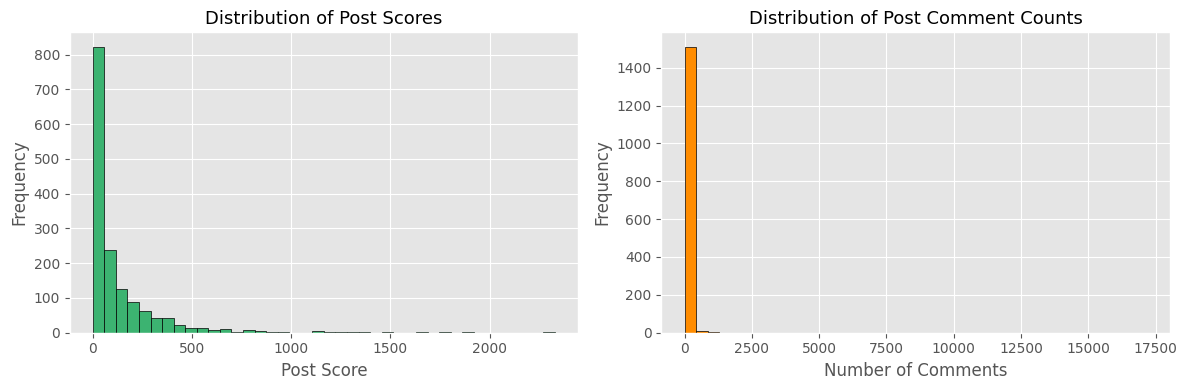

In [8]:
# VISUALIZATION 2: POST ENGAGEMENT OVERVIEW
# -------------------------------------------
# We'll visualize post popularity (score) and activity (num_comments)
# to understand which types of posts drive discussion in r/AFL.

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Distribution of post scores
ax[0].hist(posts_clean["score"], bins=40, color="mediumseagreen", edgecolor="black")
ax[0].set_title("Distribution of Post Scores", fontsize=13)
ax[0].set_xlabel("Post Score")
ax[0].set_ylabel("Frequency")

# Distribution of number of comments
ax[1].hist(posts_clean["num_comments"], bins=40, color="darkorange", edgecolor="black")
ax[1].set_title("Distribution of Post Comment Counts", fontsize=13)
ax[1].set_xlabel("Number of Comments")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


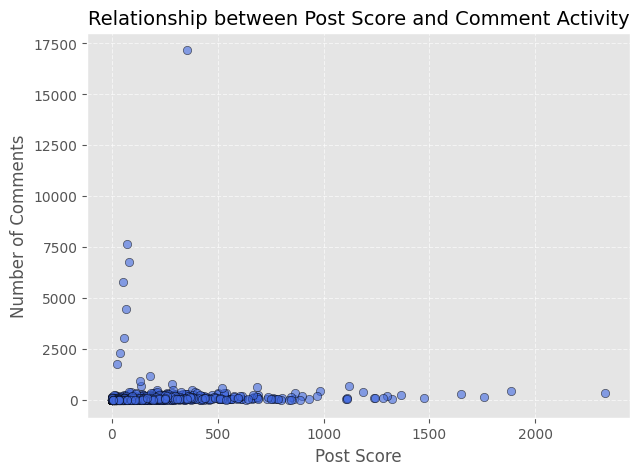

In [10]:
# VISUALIZATION 3: SCORE vs COMMENT ACTIVITY
# -------------------------------------------
# A scatterplot showing relationship between post score and comment count.
# This helps identify viral or discussion-heavy posts.

plt.figure(figsize=(7, 5))
plt.scatter(
    posts_clean["score"],
    posts_clean["num_comments"],
    alpha=0.6,
    edgecolors="k",
    color="royalblue"
)
plt.title("Relationship between Post Score and Comment Activity", fontsize=14)
plt.xlabel("Post Score")
plt.ylabel("Number of Comments")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [11]:
# ===========================================
# SECTION 4: CLEAN & COMBINE AFL MATCH RESULTS
# -------------------------------------------
# Goal:
# - Combine 2024 and 2025 AFL season data
# - Convert dates to datetime objects
# - Standardize team names and structures
# - Visualize results (margins, win counts)
# ===========================================

# Combine both datasets
afl_results = pd.concat([results_2024, results_2025], ignore_index=True)

# Convert date column to datetime
afl_results["date_utc"] = pd.to_datetime(afl_results["date_utc"], errors="coerce")

# Sort chronologically
afl_results = afl_results.sort_values(by="date_utc").reset_index(drop=True)

# Keep only key columns for analysis
afl_results = afl_results[
    ["season", "round", "date_utc", "venue", "home_team", "away_team",
     "home_score", "away_score", "winner_team", "margin", "is_final", "is_grand_final"]
]

# Ensure team name consistency (standardize)
afl_results["home_team"] = afl_results["home_team"].str.strip().str.title()
afl_results["away_team"] = afl_results["away_team"].str.strip().str.title()
afl_results["winner_team"] = afl_results["winner_team"].str.strip().str.title()

# Add a derived column: match outcome direction
afl_results["margin_direction"] = afl_results["margin"].apply(lambda x: "Win" if x > 0 else "Loss")

# Quick sanity check
print(f"Total matches: {len(afl_results)}")
print("Example rows:")
afl_results.head()


Total matches: 432
Example rows:


,season,round,date_utc,venue,home_team,away_team,home_score,away_score,winner_team,margin,is_final,is_grand_final,margin_direction
0,2024,0,2024-03-07 19:30:00,S.C.G.,Sydney,Melbourne,86,64,Sydney,22,0,0,Win
1,2024,0,2024-03-08 19:40:00,Gabba,Brisbane Lions,Carlton,85,86,Carlton,-1,0,0,Loss
2,2024,0,2024-03-09 16:20:00,Carrara,Gold Coast,Richmond,99,60,Gold Coast,39,0,0,Win
3,2024,0,2024-03-09 19:30:00,Sydney Showground,Greater Western Sydney,Collingwood,114,82,Greater Western Sydney,32,0,0,Win
4,2024,1,2024-03-14 19:30:00,M.C.G.,Carlton,Richmond,86,81,Carlton,5,0,0,Win


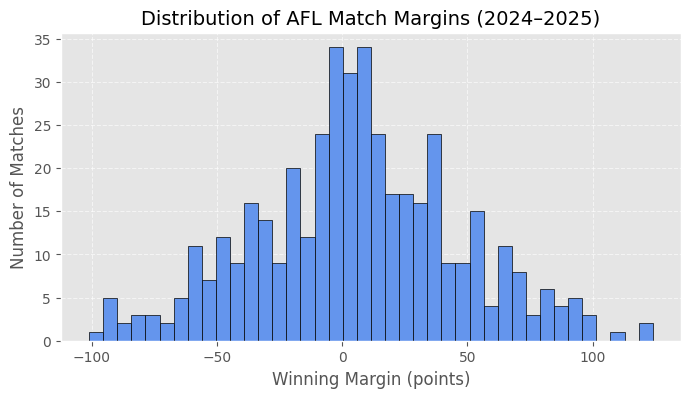

In [12]:
# VISUALIZATION 4A: DISTRIBUTION OF MATCH MARGINS
# ------------------------------------------------
# Shows how often games are close vs blowouts.

plt.figure(figsize=(8, 4))
plt.hist(afl_results["margin"], bins=40, color="cornflowerblue", edgecolor="black")
plt.title("Distribution of AFL Match Margins (2024–2025)", fontsize=14)
plt.xlabel("Winning Margin (points)")
plt.ylabel("Number of Matches")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_27884/3119993016.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=win_counts, x="wins", y="team", palette="Greens_r")


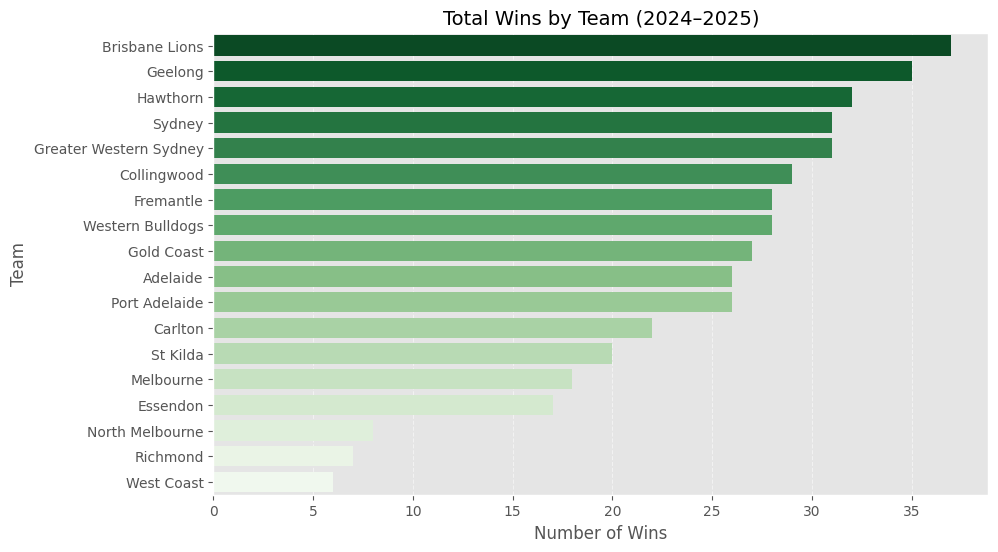

In [13]:
# VISUALIZATION 4C: WIN COUNTS PER TEAM
# ------------------------------------------------
# A quick snapshot of which teams are dominating so far.

win_counts = afl_results["winner_team"].value_counts().reset_index()
win_counts.columns = ["team", "wins"]

plt.figure(figsize=(10, 6))
sns.barplot(data=win_counts, x="wins", y="team", palette="Greens_r")
plt.title("Total Wins by Team (2024–2025)", fontsize=14)
plt.xlabel("Number of Wins")
plt.ylabel("Team")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_27884/3087223867.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_margin, x="margin", y="winner_team", palette="coolwarm")


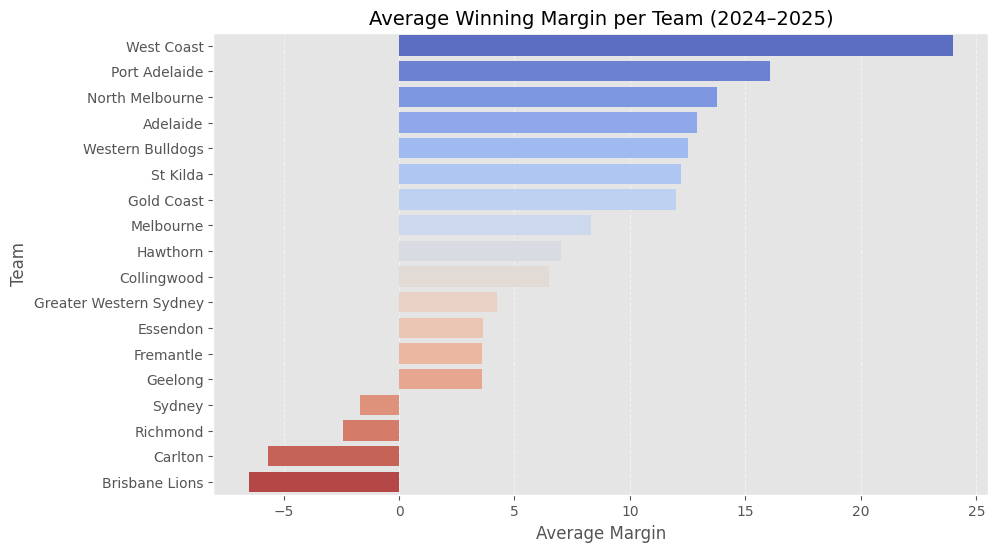

In [14]:
# VISUALIZATION 4B: AVERAGE MARGIN BY TEAM
# ------------------------------------------------
# Calculate average margin for each team (positive = strong winning trend)

avg_margin = (
    afl_results.groupby("winner_team")["margin"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_margin, x="margin", y="winner_team", palette="coolwarm")
plt.title("Average Winning Margin per Team (2024–2025)", fontsize=14)
plt.xlabel("Average Margin")
plt.ylabel("Team")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


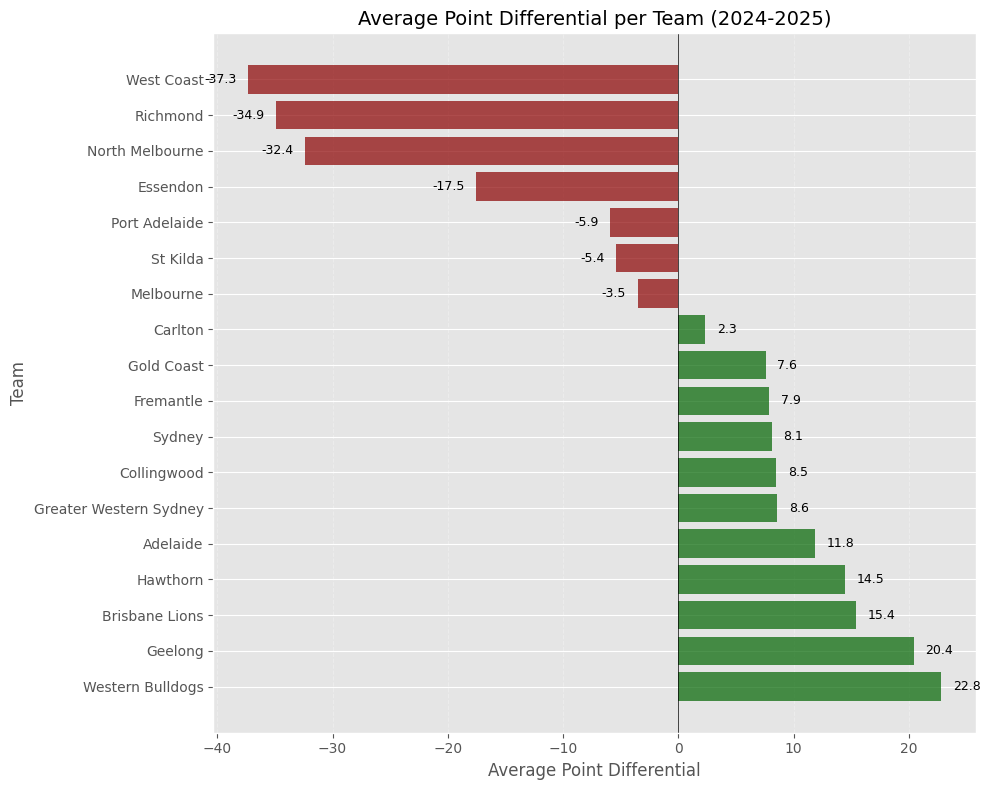

Top 5 teams by average margin:
               team  avg_margin
0  Western Bulldogs   22.787234
1           Geelong   20.431373
2    Brisbane Lions   15.444444
3          Hawthorn   14.470588
4          Adelaide   11.833333

Bottom 5 teams by average margin:
               team  avg_margin
13    Port Adelaide   -5.897959
14         Essendon  -17.521739
15  North Melbourne  -32.413043
16         Richmond  -34.934783
17       West Coast  -37.326087


In [ ]:
# VISUALIZATION 4B: AVERAGE MARGIN BY TEAM
# ------------------------------------------------
# Calculate average margin for each team (considering both wins and losses)
home_margins = afl_results.copy()
home_margins["team"] = home_margins["home_team"]
home_margins["team_margin"] = home_margins["home_score"] - home_margins["away_score"]

away_margins = afl_results.copy()
away_margins["team"] = away_margins["away_team"]
away_margins["team_margin"] = away_margins["away_score"] - away_margins["home_score"]

# Combine both home and away performances
all_margins = pd.concat([
    home_margins[["team", "team_margin"]],
    away_margins[["team", "team_margin"]]
])

# Calculate average margin per team
avg_margin = all_margins.groupby("team")["team_margin"].mean().sort_values(ascending=False).reset_index()
avg_margin.columns = ["team", "avg_margin"]

# Create visualization
plt.figure(figsize=(10, 8))
colors = ['darkgreen' if x > 0 else 'darkred' for x in avg_margin["avg_margin"]]
plt.barh(avg_margin["team"], avg_margin["avg_margin"], color=colors, alpha=0.7)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.title("Average Point Differential per Team (2024-2025)", fontsize=14)
plt.xlabel("Average Point Differential")
plt.ylabel("Team")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)

# Add value labels
for i, (team, margin) in enumerate(zip(avg_margin["team"], avg_margin["avg_margin"])):
    plt.text(margin + (1 if margin > 0 else -1), i, f'{margin:.1f}', 
             va='center', ha='left' if margin > 0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()

print("Top 5 teams by average margin:")
print(avg_margin.head())
print("\nBottom 5 teams by average margin:")
print(avg_margin.tail())

### Modeling

In [138]:
# ===========================================
# SECTION 5.1: BASELINE SENTIMENT ANALYSIS (VADER)
# -------------------------------------------
# Goal:
# Use a simple lexicon-based model to measure sentiment polarity of Reddit comments.
# This gives us a quick baseline for positivity/negativity in fan discussions.
# ===========================================

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download lexicon (only needed once)
nltk.download("vader_lexicon")

# Initialize the analyzer
vader = SentimentIntensityAnalyzer()

# Apply sentiment scoring to each comment
comments_clean["vader_score"] = comments_clean["clean_body"].apply(lambda x: vader.polarity_scores(x)["compound"])

# Define sentiment label based on compound score
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

comments_clean["sentiment_label"] = comments_clean["vader_score"].apply(label_sentiment)

# Quick overview
comments_clean[["clean_body", "vader_score", "sentiment_label"]].sample(5, random_state=42)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/diegozapataalcaraz/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,clean_body,vader_score,sentiment_label
21231,theyre not allowed to be they asked ch and got...,-0.8074,Negative
25655,how has clark still not come off for a hia he ...,0.2263,Positive
22349,couldve sworn i heard brayshaw say freo would ...,0.0000,Neutral
4112,im just looking looking forward to south austr...,0.3400,Positive
4933,,0.0000,Neutral


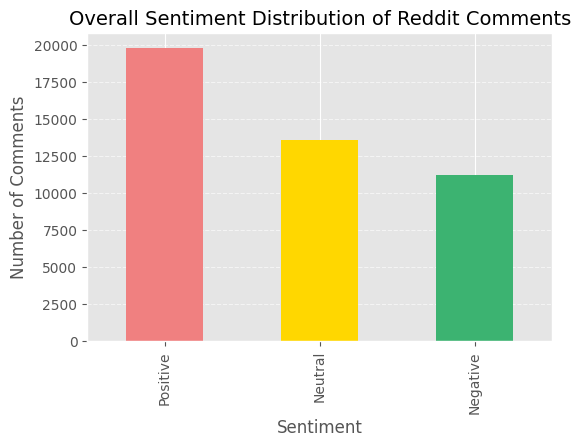

In [139]:
# VISUALIZATION 5A: SENTIMENT DISTRIBUTION
# -------------------------------------------
# Shows the share of positive, neutral, and negative comments in r/AFL discussions.

plt.figure(figsize=(6, 4))
comments_clean["sentiment_label"].value_counts().plot(kind="bar", color=["lightcoral", "gold", "mediumseagreen"])
plt.title("Overall Sentiment Distribution of Reddit Comments", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.show()


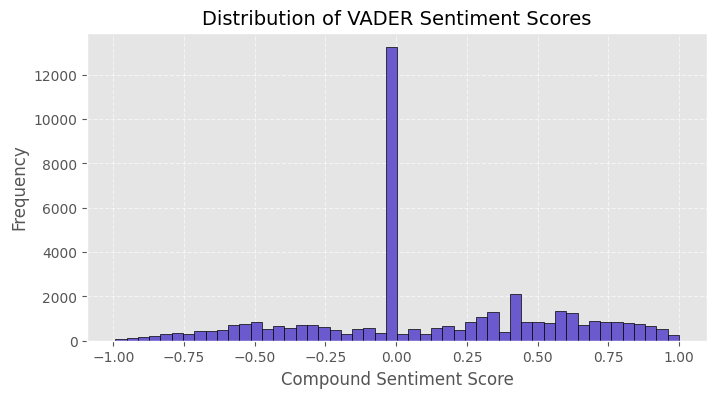

In [140]:
# VISUALIZATION 5B: SENTIMENT SCORE DISTRIBUTION
# -------------------------------------------
# Examine how compound sentiment scores are distributed across all comments.

plt.figure(figsize=(8, 4))
plt.hist(comments_clean["vader_score"], bins=50, color="slateblue", edgecolor="black")
plt.title("Distribution of VADER Sentiment Scores", fontsize=14)
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [141]:
# SENTIMENT SUMMARY
sentiment_summary = comments_clean["sentiment_label"].value_counts(normalize=True) * 100
print("Sentiment Composition (%):\n", sentiment_summary.round(2))


Sentiment Composition (%):
 sentiment_label
Positive    44.39
Neutral     30.51
Negative    25.09
Name: proportion, dtype: float64


In [142]:
# ===========================================
# SECTION 5.2: TRADITIONAL MACHINE LEARNING MODELS
# -------------------------------------------
# Goal:
# Use classic NLP + ML methods (TF-IDF + Logistic Regression / Random Forest)
# to classify fan sentiment, showing understanding of feature-based modeling.
# ===========================================

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ---------------------------------------------------
# STEP 1: Prepare labeled data
# ---------------------------------------------------
# We'll use the VADER labels as a "pseudo-labeled" dataset for now.
# Later, you can replace 'sentiment_label' with your manually labeled subset.
data_ml = comments_clean[["clean_body", "sentiment_label"]].dropna().sample(10000, random_state=42)

X = data_ml["clean_body"]
y = data_ml["sentiment_label"]

# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 8000
Testing samples: 2000


In [143]:
# ---------------------------------------------------
# STEP 2: Convert text to numerical features using TF-IDF
# ---------------------------------------------------
# TF-IDF captures how important each word is across all comments.

tfidf = TfidfVectorizer(
    max_features=5000,       # limit vocab size
    ngram_range=(1, 2),      # use unigrams and bigrams
    stop_words="english"     # remove stopwords
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF matrix shape: {X_train_tfidf.shape}")


TF-IDF matrix shape: (8000, 5000)


In [144]:
# ---------------------------------------------------
# STEP 3: Train baseline ML models
# ---------------------------------------------------
# We'll compare three standard models:
# 1. Logistic Regression (good for text)
# 2. Random Forest (nonlinear ensemble)
# 3. Linear SVM (robust classifier for high-dimensional text data)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Linear SVM": LinearSVC()
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    report = classification_report(y_test, preds, output_dict=True)
    results[name] = report["weighted avg"]["f1-score"]

# Show F1-score comparison
results_df = pd.DataFrame(results, index=["Weighted F1"]).T.sort_values(by="Weighted F1", ascending=False)
print(results_df)


                     Weighted F1
Linear SVM              0.736594
Random Forest           0.727492
Logistic Regression     0.718339


/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_27884/543191412.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y="Weighted F1", data=results_df, palette="coolwarm")


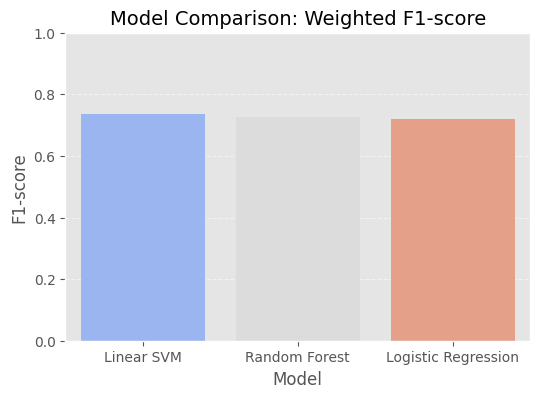

In [145]:
# VISUALIZATION 5C: MODEL PERFORMANCE COMPARISON
# -------------------------------------------
# A simple bar plot to show which model performs best on the sentiment task.

plt.figure(figsize=(6,4))
sns.barplot(x=results_df.index, y="Weighted F1", data=results_df, palette="coolwarm")
plt.title("Model Comparison: Weighted F1-score", fontsize=14)
plt.ylabel("F1-score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.show()



Classification Report for Linear SVM:

              precision    recall  f1-score   support

    Negative       0.68      0.58      0.62       508
     Neutral       0.71      0.81      0.76       596
    Positive       0.79      0.78      0.79       896

    accuracy                           0.74      2000
   macro avg       0.73      0.72      0.72      2000
weighted avg       0.74      0.74      0.74      2000



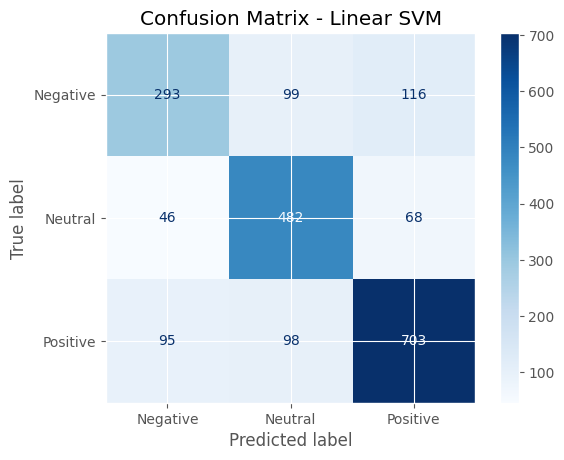

In [146]:
# ---------------------------------------------------
# STEP 4: Detailed Evaluation of the Best Model
# ---------------------------------------------------
# We'll take the best-performing model and examine confusion matrix and report.

best_model_name = results_df.index[0]
best_model = models[best_model_name]

# Predict on test set
y_pred = best_model.predict(X_test_tfidf)

# Classification report
print(f"\nClassification Report for {best_model_name}:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["Negative", "Neutral", "Positive"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()


In [ ]:
#!pip install transformers torch torchvision torchaudio --quiet


In [147]:
# ===========================================
# SECTION 5.3: TRANSFORMER-BASED MODELING (RoBERTa)
# -------------------------------------------
# Goal:
# Apply a pre-trained transformer model from Hugging Face to predict sentiment.
# This demonstrates deep learning understanding and contextual language modeling.
# ===========================================

from transformers import pipeline

# Initialize pre-trained sentiment model
# Option 1: Twitter/Reddit fine-tuned model (great for short informal text)
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# Load pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

# Apply on a sample subset to save time (you can increase later)
sample_comments = comments_clean["clean_body"].sample(5000, random_state=0).tolist()

# Run predictions
predictions = sentiment_pipeline(sample_comments, truncation=True)

# Convert to DataFrame
transformer_results = pd.DataFrame(predictions)
transformer_results.columns = ["label", "confidence"]

# Merge back to sample text
transformer_results["text"] = sample_comments

transformer_results.head()


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,label,confidence,text
0,neutral,0.854422,is that an actual quote or is this another gry...
1,positive,0.958351,loved lachie neales cameo in years later
2,neutral,0.506902,dudley is trying so hard not to be subbed off
3,neutral,0.812157,cousins and kerr were a vote away from a tie f...
4,neutral,0.631622,who was that


/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_27884/2636126123.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=transformer_results["label"], order=["negative", "neutral", "positive"], palette="coolwarm")


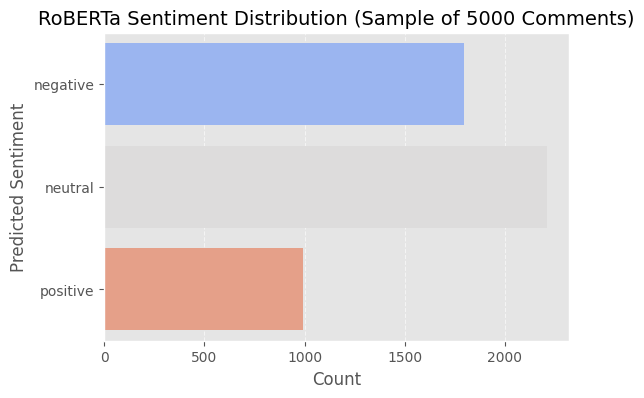

In [149]:
# ===========================================
# VISUALIZATION 5D: TRANSFORMER SENTIMENT DISTRIBUTION
# -------------------------------------------
# Visualize the share of Positive / Neutral / Negative comments
# based on RoBERTa predictions.
# ===========================================

plt.figure(figsize=(6,4))
sns.countplot(y=transformer_results["label"], order=["negative", "neutral", "positive"], palette="coolwarm")
plt.title("RoBERTa Sentiment Distribution (Sample of 5000 Comments)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Predicted Sentiment")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)
plt.show()


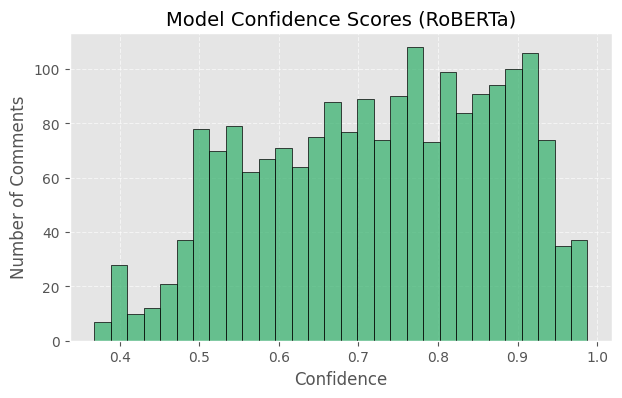

Average Confidence: 0.724


In [83]:
# ===========================================
# STEP: CONFIDENCE ANALYSIS
# -------------------------------------------
# Let's check how confident the model is in its predictions.
# ===========================================

plt.figure(figsize=(7,4))
sns.histplot(transformer_results["confidence"], bins=30, color="mediumseagreen", edgecolor="black")
plt.title("Model Confidence Scores (RoBERTa)", fontsize=14)
plt.xlabel("Confidence")
plt.ylabel("Number of Comments")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

print("Average Confidence:", round(transformer_results["confidence"].mean(), 3))


In [150]:
class AFLTeamDetector:
    def __init__(self):
        # Complete team mappings with all variations
        self.team_mappings = {
            "Adelaide": ["adelaide", "crows", "adelaide crows", "adc"],
            "Brisbane Lions": ["brisbane", "lions", "brisbane lions", "bris", "bl"],
            "Carlton": ["carlton", "blues", "carlton blues", "carl", "cfc"],
            "Collingwood": ["collingwood", "magpies", "pies", "collingwood magpies", "coll"],
            "Essendon": ["essendon", "bombers", "dons", "essendon bombers", "ess"],
            "Fremantle": ["fremantle", "dockers", "freo", "fremantle dockers", "frem"],
            "Geelong": ["geelong", "cats", "geelong cats", "geel", "gfc"],
            "Gold Coast": ["gold coast", "suns", "gold coast suns", "gcfc", "gc"],
            "Greater Western Sydney": ["gws", "giants", "greater western sydney", "gws giants", "western sydney"],
            "Hawthorn": ["hawthorn", "hawks", "hawthorn hawks", "haw", "hfc"],
            "Melbourne": ["melbourne", "demons", "dees", "melbourne demons", "melb", "mfc"],
            "North Melbourne": ["north melbourne", "kangaroos", "roos", "nmfc", "norf"],
            "Port Adelaide": ["port adelaide", "power", "port power", "pafc", "pear"],
            "Richmond": ["richmond", "tigers", "richmond tigers", "rich", "rfc", "tiges"],
            "St Kilda": ["st kilda", "saints", "stkilda", "saint kilda", "stk"],
            "Sydney": ["sydney", "swans", "sydney swans", "syd", "bloods", "south melbourne"],
            "West Coast": ["west coast", "eagles", "west coast eagles", "wce", "weagles"],
            "Western Bulldogs": ["western bulldogs", "bulldogs", "dogs", "footscray", "wb", "doggies"]
        }
        
        # Create reverse mapping for quick lookup
        self.variant_to_team = {}
        for team, variants in self.team_mappings.items():
            for variant in variants:
                self.variant_to_team[variant] = team
        
        # Compile regex patterns for each team's variants
        self.team_patterns = {}
        for team, variants in self.team_mappings.items():
            # Sort by length (longest first) to match longer phrases first
            sorted_variants = sorted(variants, key=len, reverse=True)
            # Escape special regex characters and create word boundary patterns
            pattern_parts = [r'\b' + re.escape(v) + r'\b' for v in sorted_variants]
            self.team_patterns[team] = re.compile('|'.join(pattern_parts), re.IGNORECASE)
    
    def detect_teams_regex(self, text):
        """
        Detect teams using regex patterns
        """
        detected_teams = []
        for team, pattern in self.team_patterns.items():
            if pattern.search(text):
                detected_teams.append(team)
        return detected_teams



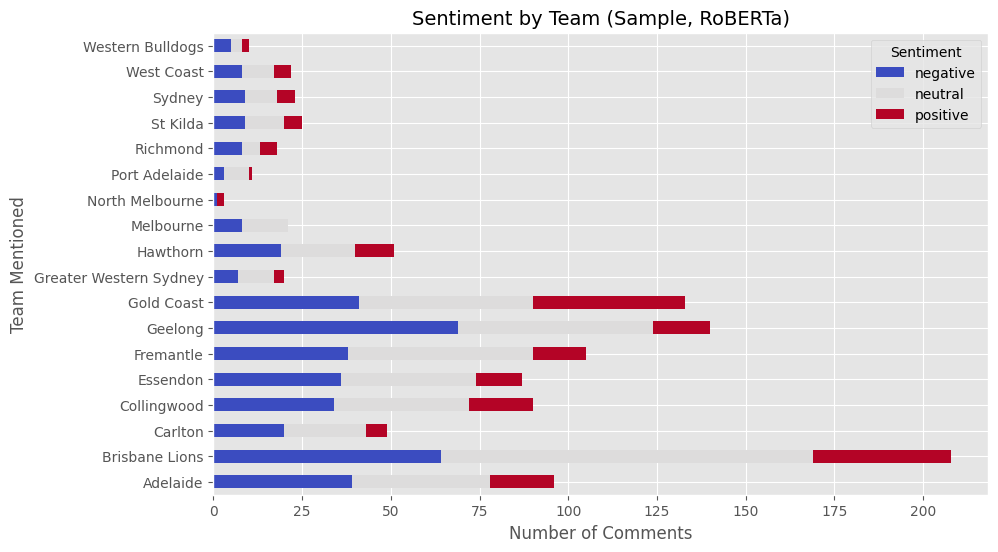

In [153]:
# ===========================================
# STEP: AGGREGATE SENTIMENT BY TEAM (if team mentioned)
# -------------------------------------------
# Optional: simple rule-based team mention detection
# This prepares us for linking sentiment to AFL match results later.
# ===========================================

# Example dictionary of team names for detection
teams = [
    "West Coast", "Port Adelaide", "North Melbourne", "Adelaide", "Western Bulldogs",
    "St Kilda", "Gold Coast", "Melbourne", "Hawthorn", "Collingwood",
    "Greater Western Sydney", "Essendon", "Fremantle", "Geelong",
    "Sydney", "Richmond", "Brisbane Lions", "Carlton"
]

# # Create simple detection column
# def detect_team(text):
#     for team in teams:
#         if team.lower() in text.lower():
#             return team
#     return None

# transformer_results["team_mentioned"] = transformer_results["text"].apply(detect_team)

# Class
detector = AFLTeamDetector()

# Apply to your dataframe
def detect_team(text):
    teams = detector.detect_teams_regex(text)
    # Return first team if multiple detected, or None
    return teams[0] if teams else None

# Apply functions
transformer_results["team_mentioned"] = transformer_results["text"].apply(detect_team)


# Group by team to see which fanbases have most positive/negative tone
team_sentiment = (
    transformer_results.groupby(["team_mentioned", "label"])
    .size()
    .reset_index(name="count")
    .pivot(index="team_mentioned", columns="label", values="count")
    .fillna(0)
)

team_sentiment.plot(kind="barh", stacked=True, figsize=(10,6), colormap="coolwarm")
plt.title("Sentiment by Team (Sample, RoBERTa)", fontsize=14)
plt.xlabel("Number of Comments")
plt.ylabel("Team Mentioned")
plt.legend(title="Sentiment")
plt.show()


In [ ]:
# ===========================================
# SECTION 6.1: DATA INTEGRATION
# -------------------------------------------
# Goal:
# Combine sentiment predictions with AFL match outcomes
# to explore how team performance affects fan sentiment.
# ===========================================

# Ensure we have team mentions from earlier
if "team_mentioned" not in transformer_results.columns:
    teams = [
    "West Coast", "Port Adelaide", "North Melbourne", "Adelaide", "Western Bulldogs",
    "St Kilda", "Gold Coast", "Melbourne", "Hawthorn", "Collingwood",
    "Greater Western Sydney", "Essendon", "Fremantle", "Geelong",
    "Sydney", "Richmond", "Brisbane Lions", "Carlton"
]

transformer_results["team_mentioned"] = transformer_results["text"].apply(detect_team)

# Convert confidence and label to numeric sentiment score
sentiment_map = {"negative": -1, "neutral": 0, "positive": 1}
transformer_results["sentiment_score"] = transformer_results["label"].map(sentiment_map)

# Clean merge columns
afl_results["date_utc"] = pd.to_datetime(afl_results["date_utc"], errors="coerce")
transformer_results["team_mentioned"] = transformer_results["team_mentioned"].str.title()

# Group by team to calculate average sentiment
team_sentiment_summary = (
    transformer_results.groupby("team_mentioned")
    .agg(avg_sentiment=("sentiment_score", "mean"), n_comments=("sentiment_score", "count"))
    .reset_index()
    .dropna(subset=["team_mentioned"])
)

team_sentiment_summary.head(25)


,team_mentioned,avg_sentiment,n_comments
0,Adelaide,-0.218750,96
1,Brisbane Lions,-0.120192,208
2,Carlton,-0.285714,49
3,Collingwood,-0.177778,90
4,Essendon,-0.264368,87
5,Fremantle,-0.219048,105
6,Geelong,-0.378571,140
7,Gold Coast,0.015038,133
8,Greater Western Sydney,-0.200000,20
9,Hawthorn,-0.156863,51


In [155]:
# ===========================================
# SECTION 6.2: SENTIMENT VS PERFORMANCE
# -------------------------------------------
# Combine average fan sentiment with team win stats
# ===========================================

# Calculate team performance summary
team_performance = (
    afl_results.groupby("winner_team")
    .agg(
        wins=("winner_team", "count"),
        avg_margin=("margin", "mean")
    )
    .reset_index()
    .rename(columns={"winner_team": "team"})
)

# Merge with sentiment summary
merged_insights = pd.merge(
    team_sentiment_summary,
    team_performance,
    left_on="team_mentioned",
    right_on="team",
    how="inner"
)

merged_insights = merged_insights.sort_values(by="avg_sentiment", ascending=False)
merged_insights.head(10)


,team_mentioned,avg_sentiment,n_comments,team,wins,avg_margin
11,North Melbourne,0.333333,3,North Melbourne,8,13.750000
7,Gold Coast,0.015038,133,Gold Coast,27,12.000000
1,Brisbane Lions,-0.120192,208,Brisbane Lions,37,-6.513514
16,West Coast,-0.136364,22,West Coast,6,24.000000
9,Hawthorn,-0.156863,51,Hawthorn,32,7.000000
14,St Kilda,-0.160000,25,St Kilda,20,12.200000
13,Richmond,-0.166667,18,Richmond,7,-2.428571
15,Sydney,-0.173913,23,Sydney,31,-1.709677
3,Collingwood,-0.177778,90,Collingwood,29,6.482759
12,Port Adelaide,-0.181818,11,Port Adelaide,26,16.076923


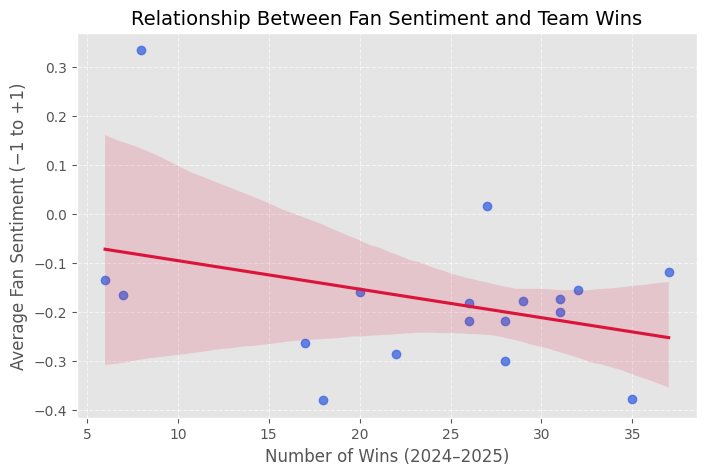

Correlation between Wins and Sentiment: -0.35


In [156]:
# VISUALIZATION 6A: FAN SENTIMENT vs WINS
plt.figure(figsize=(8, 5))
sns.regplot(
    data=merged_insights,
    x="wins",
    y="avg_sentiment",
    scatter_kws={"color": "royalblue"},
    line_kws={"color": "crimson"}
)
plt.title("Relationship Between Fan Sentiment and Team Wins", fontsize=14)
plt.xlabel("Number of Wins (2024–2025)")
plt.ylabel("Average Fan Sentiment (−1 to +1)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Correlation
corr_wins = merged_insights["wins"].corr(merged_insights["avg_sentiment"])
print(f"Correlation between Wins and Sentiment: {corr_wins:.2f}")


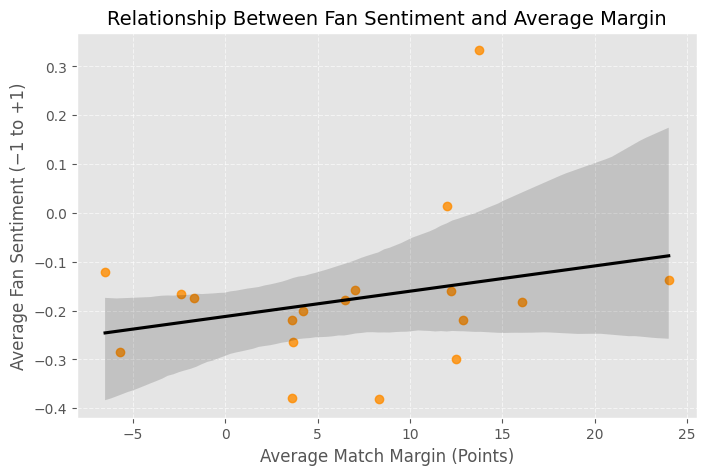

Correlation between Margin and Sentiment: 0.26


In [157]:
# VISUALIZATION 6B: FAN SENTIMENT vs AVERAGE MARGIN
plt.figure(figsize=(8, 5))
sns.regplot(
    data=merged_insights,
    x="avg_margin",
    y="avg_sentiment",
    scatter_kws={"color": "darkorange"},
    line_kws={"color": "black"}
)
plt.title("Relationship Between Fan Sentiment and Average Margin", fontsize=14)
plt.xlabel("Average Match Margin (Points)")
plt.ylabel("Average Fan Sentiment (−1 to +1)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

corr_margin = merged_insights["avg_margin"].corr(merged_insights["avg_sentiment"])
print(f"Correlation between Margin and Sentiment: {corr_margin:.2f}")


/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_27884/498803412.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


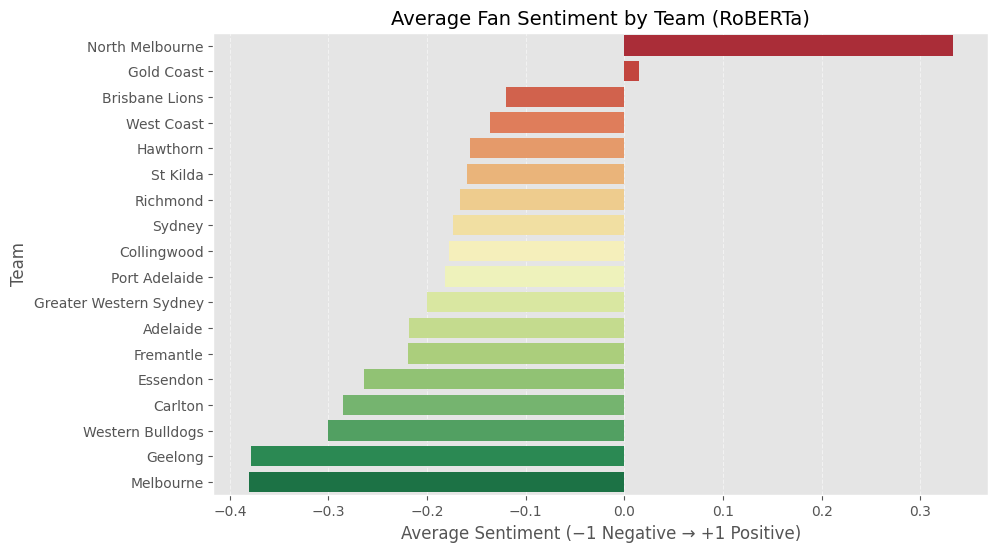

In [158]:
# VISUALIZATION 6C: TEAM SENTIMENT RANKINGS
plt.figure(figsize=(10, 6))
sns.barplot(
    data=merged_insights.sort_values(by="avg_sentiment", ascending=False),
    y="team_mentioned", x="avg_sentiment", palette="RdYlGn"
)
plt.title("Average Fan Sentiment by Team (RoBERTa)", fontsize=14)
plt.xlabel("Average Sentiment (−1 Negative → +1 Positive)")
plt.ylabel("Team")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_27884/1337951984.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=team_variance, y="team_mentioned", x="sentiment_volatility", palette="coolwarm")


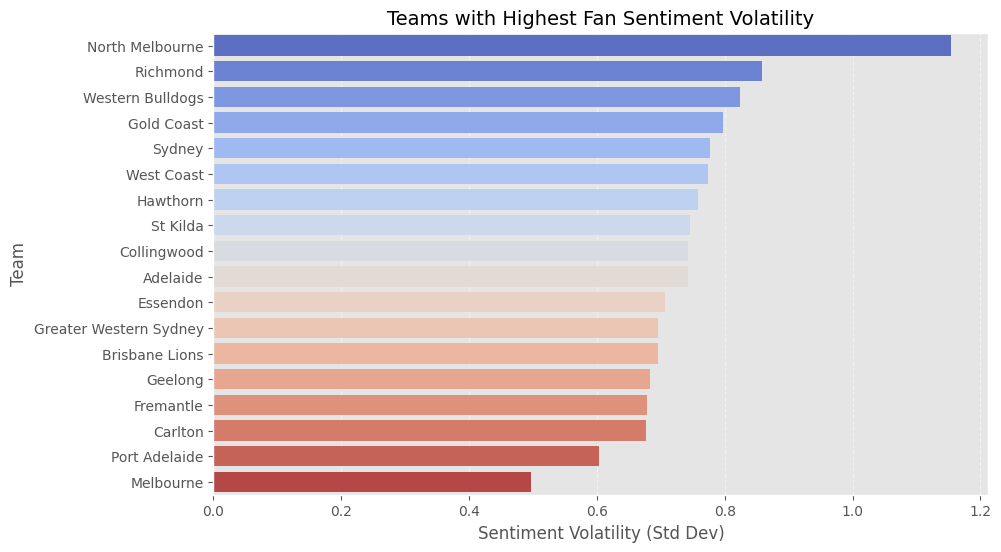

In [159]:
# ===========================================
# SECTION 6.3: EMOTIONALLY AFFECTED TEAMS
# -------------------------------------------
# Identify teams whose fan sentiment shifts most with win/loss margin
# ===========================================

# For each team, measure sentiment variance (higher = more volatile mood)
team_variance = (
    transformer_results.groupby("team_mentioned")
    .agg(sentiment_volatility=("sentiment_score", "std"))
    .reset_index()
    .sort_values(by="sentiment_volatility", ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(data=team_variance, y="team_mentioned", x="sentiment_volatility", palette="coolwarm")
plt.title("Teams with Highest Fan Sentiment Volatility", fontsize=14)
plt.xlabel("Sentiment Volatility (Std Dev)")
plt.ylabel("Team")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


Device set to use mps:0
/var/folders/6h/7_s8d7dn5p565dythb22sn0c0000gn/T/ipykernel_27884/1142592800.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="emotion", data=emotion_df, order=emotion_df["emotion"].value_counts().index, palette="Spectral")


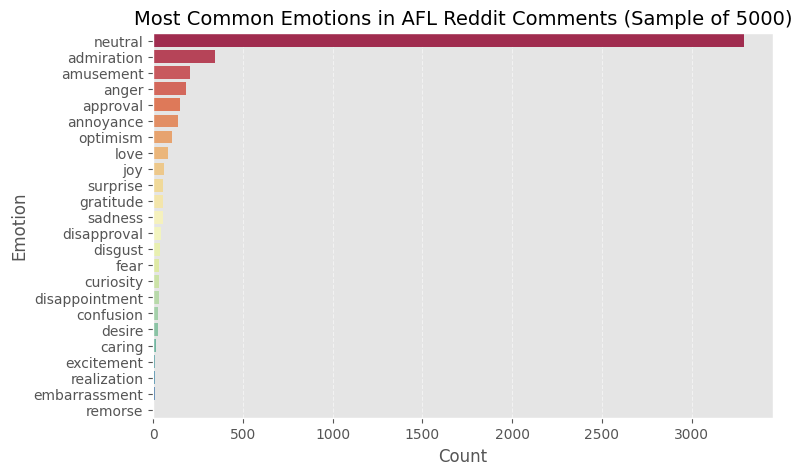

In [160]:
# ===========================================
# SECTION 6B: EMOTION DETECTION (GoEmotions)
# -------------------------------------------
# Goal:
# Use a pre-trained emotion classification model to detect
# dominant emotions in AFL fan comments.
# ===========================================

from transformers import pipeline

# Load GoEmotions model (lightweight)
emotion_model = pipeline("text-classification", model="bhadresh-savani/bert-base-go-emotion", top_k=1)

# Take a random sample to avoid slow inference (adjust as needed)
# sample_comments = comments_clean["clean_body"].sample(2000, random_state=0).tolist()

# Predict emotions
emotion_preds = emotion_model(sample_comments)

# Extract top label per comment
emotion_labels = [p[0]['label'] for p in emotion_preds]

# Create DataFrame
emotion_df = pd.DataFrame({
    "text": sample_comments,
    "emotion": emotion_labels
})

# Visualize top emotions
plt.figure(figsize=(8, 5))
sns.countplot(y="emotion", data=emotion_df, order=emotion_df["emotion"].value_counts().index, palette="Spectral")
plt.title("Most Common Emotions in AFL Reddit Comments (Sample of 5000)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Emotion")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()


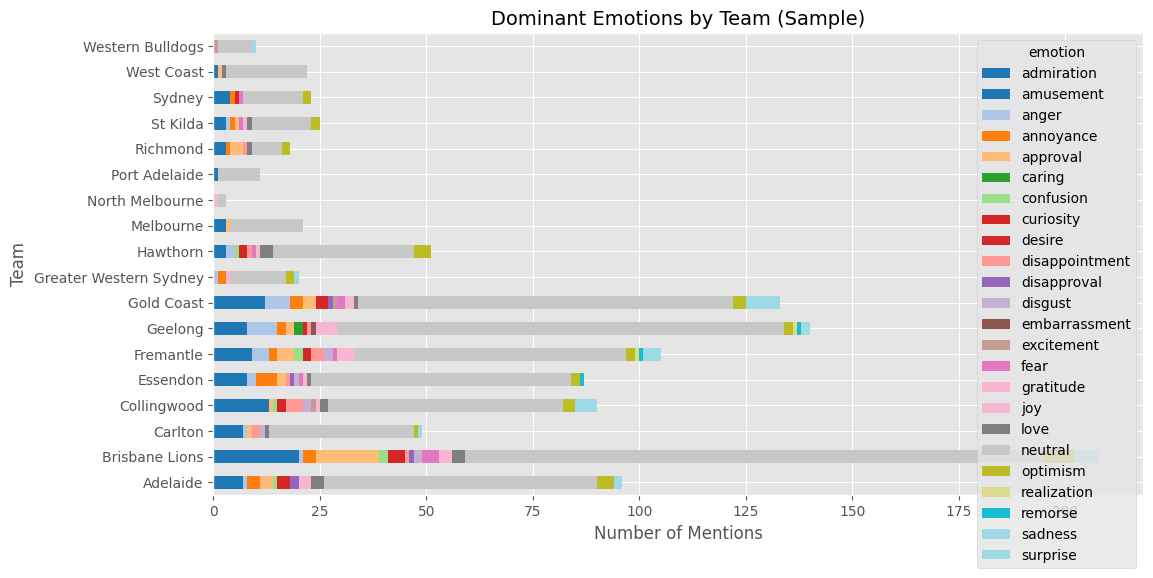

In [161]:
# Team-level emotion frequency
emotion_df["team_mentioned"] = emotion_df["text"].apply(detect_team)

team_emotions = (
    emotion_df.groupby(["team_mentioned", "emotion"])
    .size()
    .reset_index(name="count")
    .pivot(index="team_mentioned", columns="emotion", values="count")
    .fillna(0)
)

team_emotions.plot(kind="barh", stacked=True, figsize=(12, 6), colormap="tab20")
plt.title("Dominant Emotions by Team (Sample)", fontsize=14)
plt.xlabel("Number of Mentions")
plt.ylabel("Team")
plt.show()


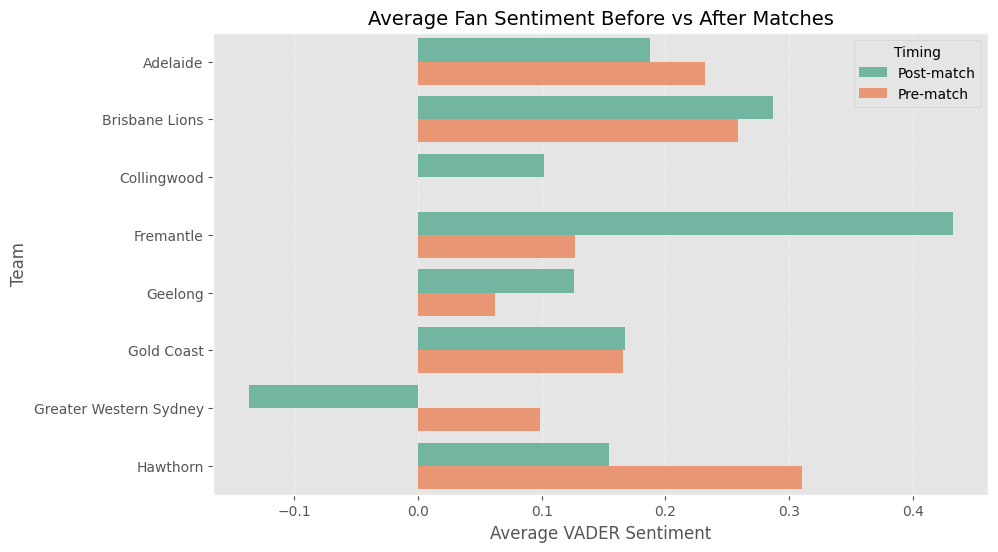

In [166]:
# ===========================================
# SECTION 6D: PRE- vs POST-MATCH SENTIMENT
# -------------------------------------------
# Goal:
# Compare average sentiment before and after matches for each team.
# ===========================================

# Ensure datetime formats are aligned
afl_results["date_utc"] = pd.to_datetime(afl_results["date_utc"], errors="coerce")
comments_clean["created_utc"] = pd.to_datetime(comments_clean["created_datetime_utc"], errors="coerce")

# Detect team in each comment
comments_clean["team_mentioned"] = comments_clean["clean_body"].apply(detect_team)

# Merge by nearest match date (±1 day window)
def match_relation(comment_time, match_date):
    diff_days = (comment_time - match_date).days
    if -1 <= diff_days <= 0:
        return "Pre-match"
    elif 0 < diff_days <= 1:
        return "Post-match"
    else:
        return None

# Prepare results
pre_post_data = []

for _, match in afl_results.iterrows():
    match_date = match["date_utc"]
    
    for team in [match["home_team"], match["away_team"]]:
        # Create mask for team and time window
        mask = (comments_clean["team_mentioned"] == team) & \
               (abs((comments_clean["created_utc"] - match_date).dt.total_seconds() / 86400) <= 2)
        
        matched_comments = comments_clean[mask]
        
        if len(matched_comments) > 0:
            tmp = matched_comments[["vader_score", "created_utc"]].copy()
            tmp["team"] = team
            tmp["match_date"] = match_date
            tmp["relation"] = tmp["created_utc"].apply(lambda x: match_relation(x, match_date))
            # Filter out None relations
            tmp = tmp[tmp["relation"].notna()]
            if len(tmp) > 0:
                pre_post_data.append(tmp)

pre_post_df = pd.concat(pre_post_data, ignore_index=True)

# Compute averages
pre_post_summary = (
    pre_post_df.groupby(["team", "relation"])["vader_score"]
    .mean()
    .reset_index()
)

# Visualization
plt.figure(figsize=(10,6))
sns.barplot(data=pre_post_summary, x="vader_score", y="team", hue="relation", palette="Set2")
plt.title("Average Fan Sentiment Before vs After Matches", fontsize=14)
plt.xlabel("Average VADER Sentiment")
plt.ylabel("Team")
plt.legend(title="Timing")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()
